In [1]:
import typing
import numpy as np
import tvm
from tvm import relax, relay
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from tvm.contrib import graph_executor

In [2]:
import os
import onnx

dir_path = "/home/arthur/Desktop/Projects/fromsource/d2l-tvm/tvm-tuto/myown/models/"
model_name = "mnist12" # tinyyolov2

model_path = os.path.join(dir_path, model_name, "Model.onnx")

onnx_model = onnx.load(model_path)
onnx_model

ir_version: 7
producer_name: "CNTK"
producer_version: "2.5.1"
domain: "ai.cntk"
model_version: 1
graph {
  node {
    input: "Input3"
    input: "Parameter5"
    output: "Convolution28_Output_0"
    name: "Convolution28"
    op_type: "Conv"
    attribute {
      name: "kernel_shape"
      ints: 5
      ints: 5
      type: INTS
    }
    attribute {
      name: "strides"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "auto_pad"
      s: "SAME_UPPER"
      type: STRING
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    doc_string: ""
    domain: ""
  }
  node {
    input: "Convolution28_Output_0"
    input: "Parameter6"
    output: "Plus30_Output_0"
    name: "Plus30"
    op_type: "Add"
    doc_string: ""
    domain: ""
  }
  node {
    input: "Plus30_Output_0"
    output: "ReLU32_Output_0"
    name: "ReLU32"
    op_type: "Relu"
    doc_st

In [ ]:
# We need to know the name and shape of the input tensor
onnx_model.graph.input[0]

name: "Input3"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 28
      }
      dim {
        dim_value: 28
      }
    }
  }
}

## Define a test image

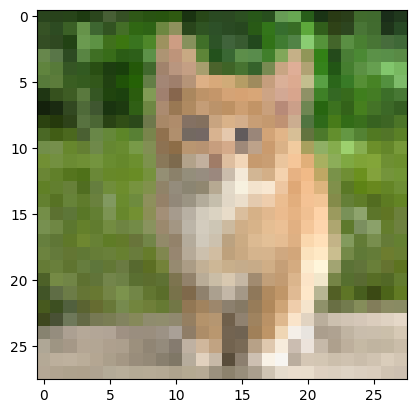

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
from tvm.contrib.download import download_testdata

# This is clearly not a MNIST image, but whatever
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((28, 28)) #.resize((416, 416))
plt.imshow(img)

(1, 1, 28, 28) uint8


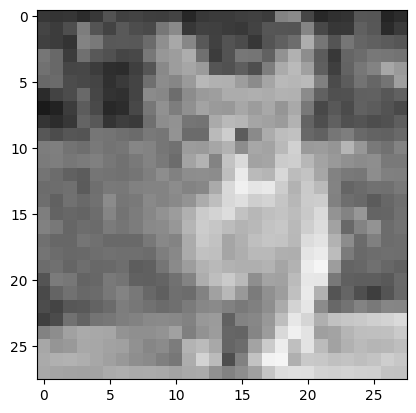

In [18]:
img_ycbcr = img.convert("YCbCr")  # convert to YCbCr
img_y, img_cb, img_cr = img_ycbcr.split()
x = np.array(img_y)[np.newaxis, np.newaxis, :, :]
print(x.shape, x.dtype)
plt.imshow(x.squeeze(), cmap="gray", vmin=0, vmax=255)

## ONNX ==> Relay IR

In [20]:
target = "llvm"

input_name = "Input3"
shape_dict = {input_name: x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

[10:35:19] /home/arthur/Desktop/Projects/fromsource/d2l-tvm/tvm/src/runtime/threading_backend.cc:346: Warning: more than two frequencies detected! Forced big_count_ to 16


## Experimental feature : Relay => Relax

In [22]:
from tvm.relax.testing.relay_translator import from_relay

relax_mod = from_relay(mod["main"], target="llvm")
relax_mod.show()

In [24]:
lib = tvm.relay.build(mod, target=target, params=params)
graph_mod = graph_executor.GraphModule(lib["default"](tvm.cpu()))
graph_mod

In [27]:
print(graph_mod.benchmark(tvm.cpu(), number=2, repeat=100))
# Performance is extremely bad :)

Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.2191       0.2150       0.2984       0.1418       0.0403                  
